In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


images = np.load(r"C:\\Users\\18014\\Desktop\\images.npy")
labels = pd.read_csv(r"C:\\Users\\18014\\Desktop\\labels.csv")

#Checking the shape of the data
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (4750, 128, 128, 3)
Labels shape: (4750, 1)


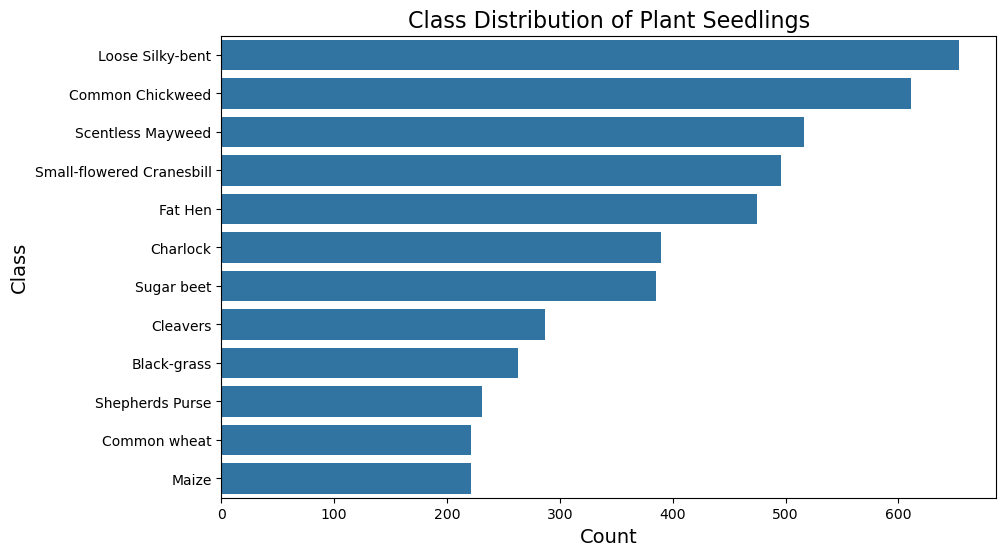

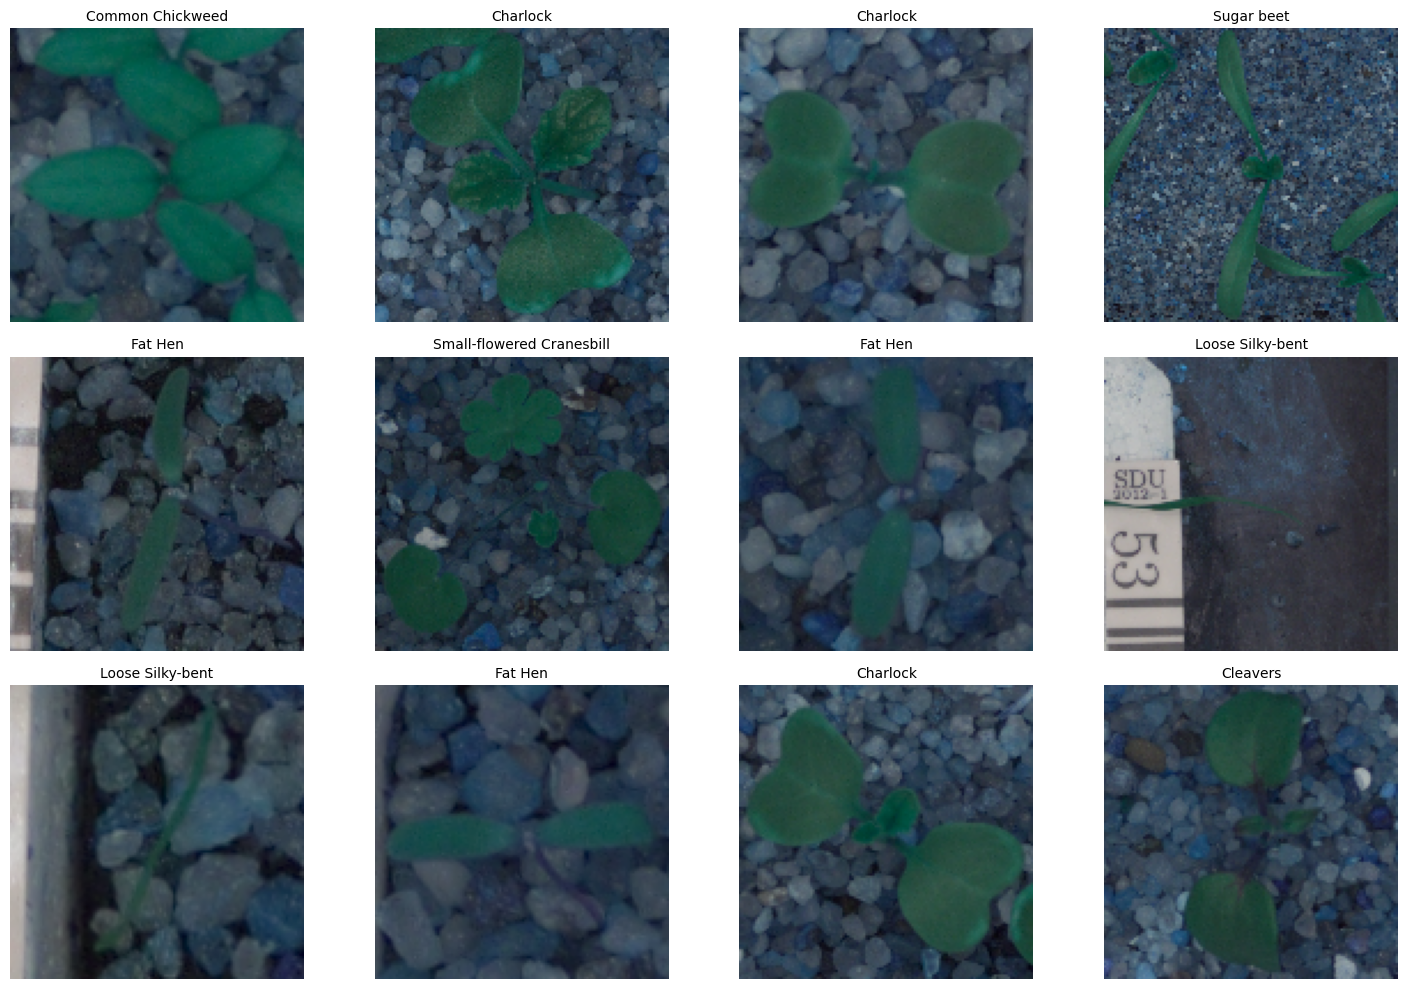

In [2]:
#Creating a visualization for class distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=labels['Label'], order=labels['Label'].value_counts().index)
plt.title("Class Distribution of Plant Seedlings", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()

#Displaying 12 random images with labels
num_samples = 12
indices = np.random.choice(range(images.shape[0]), num_samples, replace=False)
sample_images = images[indices]
sample_labels = labels['Label'].iloc[indices]

#Plotting the samples
plt.figure(figsize=(15, 10))
for i, (img, lbl) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.astype('uint8'))
    plt.title(lbl, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


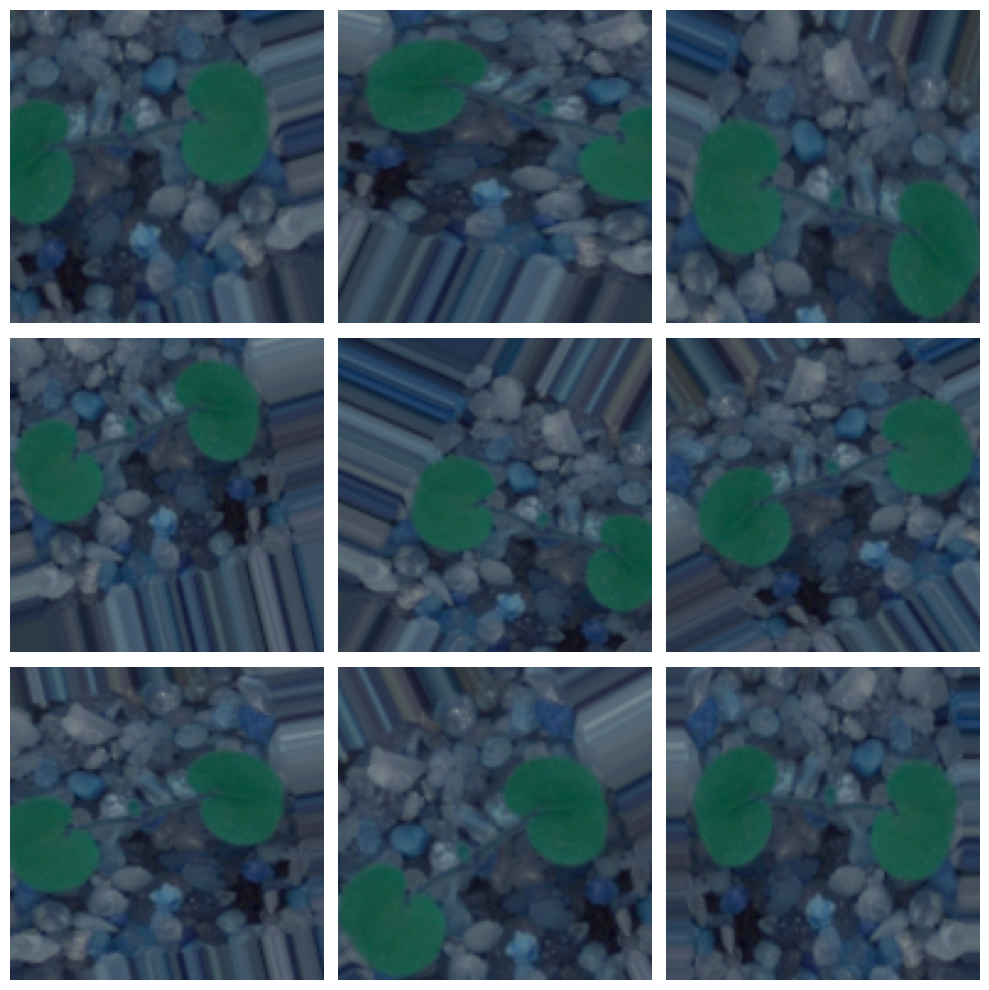

In [3]:
#Data Augmentation
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Creating visualizations of the augmented images Augmented Images
sample_image = images[0].astype('uint8')
sample_image = np.expand_dims(sample_image, axis=0)

plt.figure(figsize=(10, 10))
for i, augmented in enumerate(augmenter.flow(sample_image, batch_size=1)):
    if i == 9:
        break
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented[0].astype('uint8'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
#Normalizing images, pixel values to range [0, 1]
images = images / 255.0

#Encoding the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels['Label'])

#Splitting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.3, random_state=1, stratify=labels_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

#Target Feature Encoding (One-hot encoding)

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

In [28]:
#Inspecting encoding, checking data distribution as part of troubleshooting the low accuracy problem
print(label_encoder.classes_)
print(np.unique(y_test))

print(labels['Label'].value_counts())

['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
[ 0  1  2  3  4  5  6  7  8  9 10 11]
Label
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: count, dtype: int64
Index(['Label'], dtype='object')


In [6]:
#Saving the datasets
#np.save(r"C:\\Users\\18014\\Desktop\\X_train.npy", X_train)
#np.save(r"C:\\Users\\18014\\Desktop\\y_train.npy", y_train_encoded)

#np.save(r"C:\\Users\\18014\\Desktop\\X_val.npy", X_val)
#np.save(r"C:\\Users\\18014\\Desktop\\y_val.npy", y_val_encoded)

#np.save(r"C:\\Users\\18014\\Desktop\\X_test.npy", X_test)
#np.save(r"C:\\Users\\18014\\Desktop\\y_test.npy", y_test_encoded)


In [7]:
#Define the neural network model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

#Compiling the model and optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\18014\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,868 (28.21 MB)

 Trainable params: 7,393,868 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#Defining early stopping and patience parameter
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Computing class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

#Training the model with class weights
history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                    epochs=50, batch_size=32, callbacks=[early_stopping],
                    class_weight=class_weights_dict)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.1440 - loss: 2.5119 - val_accuracy: 0.3258 - val_loss: 1.8522
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.3238 - loss: 1.8225 - val_accuracy: 0.4466 - val_loss: 1.4549
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.4324 - loss: 1.4965 - val_accuracy: 0.5590 - val_loss: 1.3194
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.5474 - loss: 1.2767 - val_accuracy: 0.6208 - val_loss: 1.1374
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.6008 - loss: 1.1094 - val_accuracy: 0.6784 - val_loss: 1.0207
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.6449 - loss: 1.0167 - val_accuracy: 0.6756 - val_loss: 1.0130
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.6833 - loss: 0.9147 - val_accuracy: 0.6840 - val_loss: 0.9721
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.7102 - loss: 0

In [14]:
#Accuracy test calcuation
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {test_acc}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6701 - loss: 1.0045
Test Accuracy: 0.678821861743927


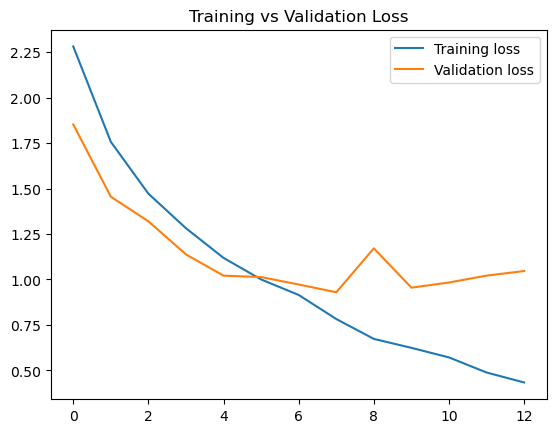

In [16]:
#Plot comparing training loss to validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [18]:
#Generating a confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

cm

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


array([[17,  0,  0,  0,  4,  1, 15,  0,  1,  0,  1,  0],
       [ 0, 47,  4,  0,  0,  0,  0,  0,  0,  2,  0,  5],
       [ 0,  0, 36,  0,  1,  0,  0,  1,  5,  0,  0,  0],
       [ 0,  0,  0, 69,  1,  1,  0,  7,  3,  9,  1,  1],
       [ 7,  0,  0,  0, 23,  1,  0,  0,  2,  0,  0,  0],
       [ 1,  3,  6,  2,  4, 44,  1,  3,  2,  3,  0,  3],
       [39,  0,  1,  0,  6,  3, 46,  0,  1,  0,  0,  2],
       [ 0,  0,  1,  4,  0,  0,  0, 22,  2,  2,  0,  2],
       [ 4,  3,  0,  1,  0,  0,  1,  4, 59,  1,  0,  5],
       [ 0,  0,  0,  2,  0,  2,  0,  3,  2, 21,  4,  0],
       [ 0,  0,  3,  0,  0,  1,  2,  0,  1,  4, 64,  0],
       [ 0,  1,  1,  1,  1,  4,  0,  3,  8,  1,  2, 36]], dtype=int64)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


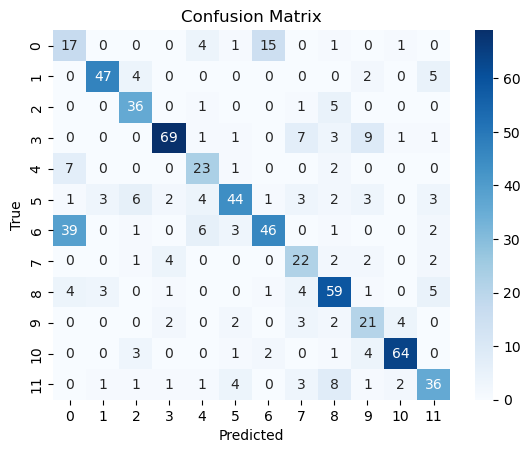

In [20]:
#Creating a heatmap confsion matrix
cm = confusion_matrix(y_test, np.argmax(model.predict(X_test), axis=1))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

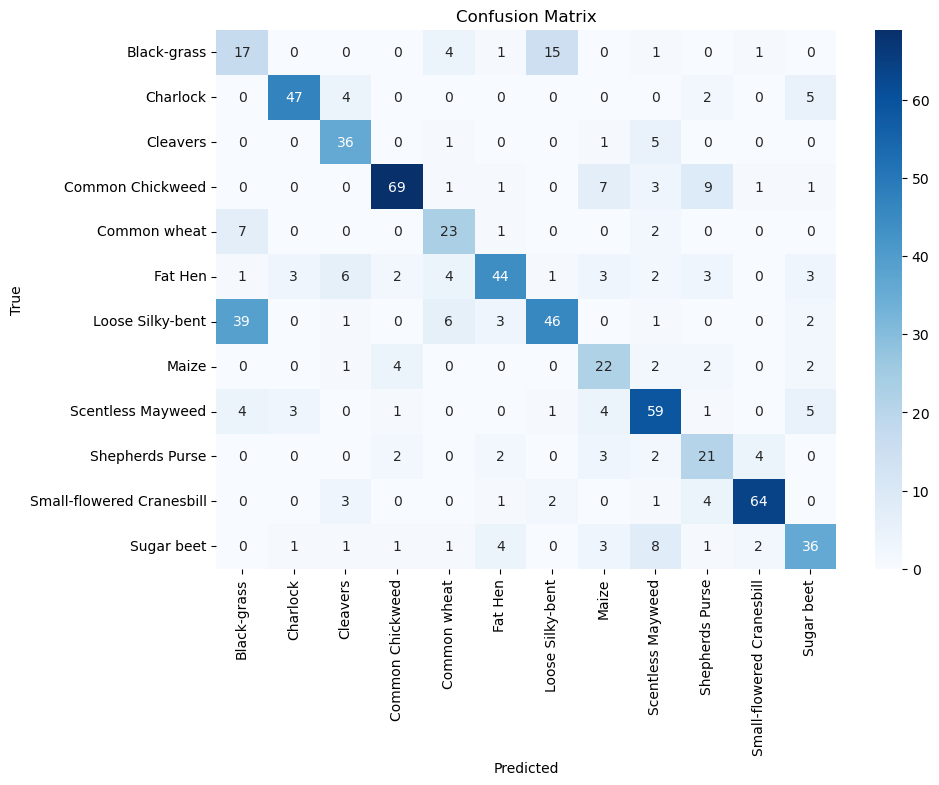

In [22]:
#Creating a bigger heatmap confsion matrix with specific labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
#Saving the
model.save(r"C:\\Users\\18014\\Desktop\\plant_seedling_classifier.h5")

In [36]:
#Exporting as html
!jupyter nbconvert --to html "D604 Task 1A.ipynb" --output "C:/Users/18014/Desktop/D604_Task_1A.html"